In [18]:
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [25]:
# Matplotlib figure size to have large enough image plotting
FIGURE_SIZE = (12, 6)

def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    """ A helper for plotting a grayscale image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

In [75]:
IMG_PATH = "/home/rattus/Free/Udacity/CarND-Capstone/imgs/traffic/samples"
images = os.listdir(IMG_PATH)
images.sort()

In [76]:
def clamp_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sat = hsv[:,:,1]
    val = hsv[:,:,2]
    mask = np.zeros(sat.shape)
    mask[sat > 180] += 100
    mask[val > 150] += 100
    mask[mask < 200] = 0
    
    print("Sat (", mask.shape, ") stat min/mean/max ", sat.min(), sat.mean(), sat.max())
    return mask

Sat ( (600, 800) ) stat min/mean/max  0 99.16577708333334 255
Sat ( (600, 800) ) stat min/mean/max  0 99.39811458333334 255
Sat ( (600, 800) ) stat min/mean/max  0 174.91989166666667 255
Sat ( (600, 800) ) stat min/mean/max  0 176.17655 255
Sat ( (600, 800) ) stat min/mean/max  0 96.91144791666666 255


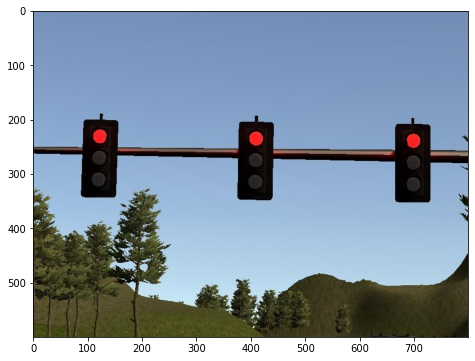

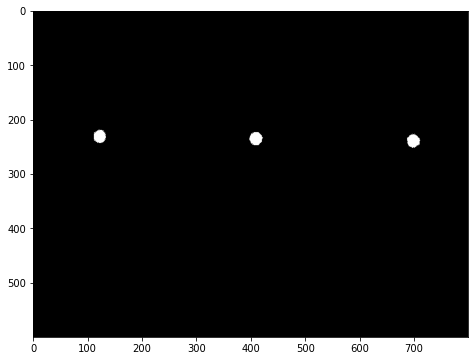

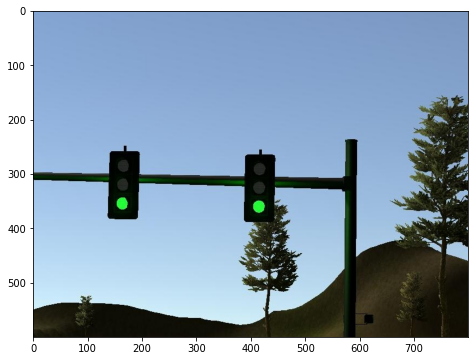

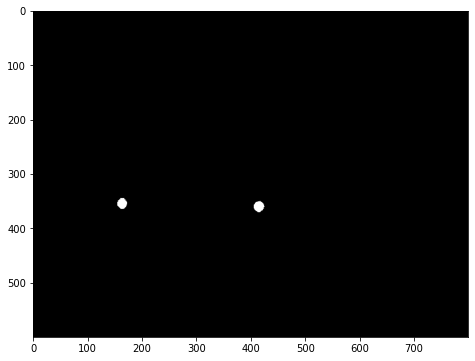

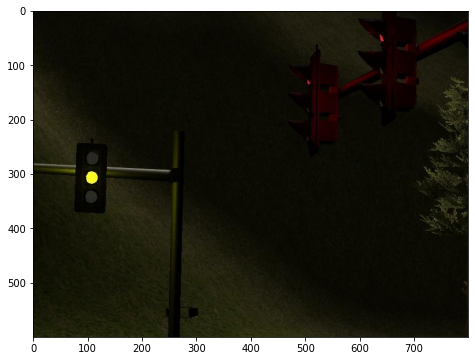

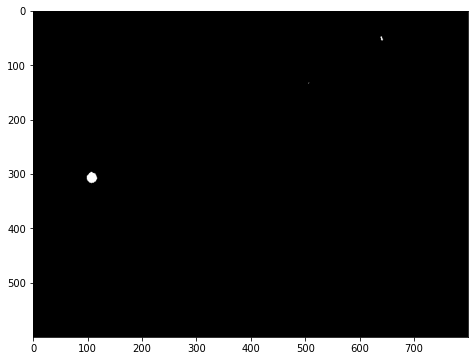

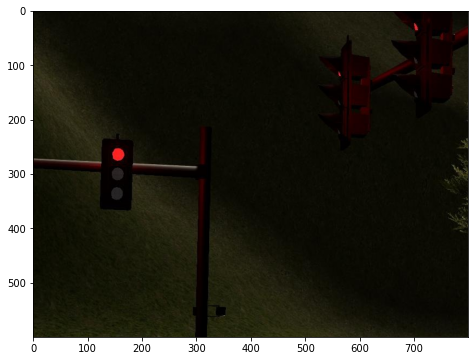

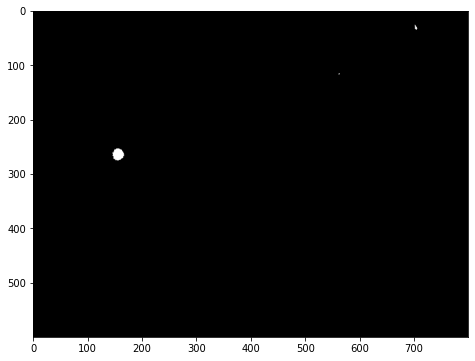

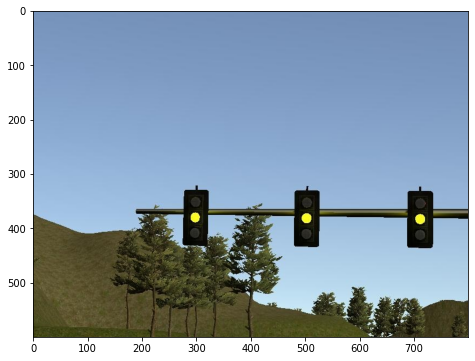

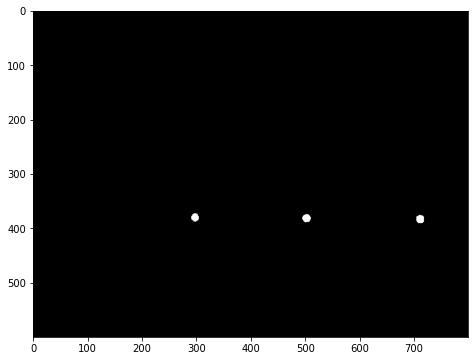

In [77]:
for i in range(5):
    img = cv2.imread(os.path.join(IMG_PATH, images[i]))
    plot_bgr(img)

    plot_gray(clamp_saturation(img))